In [258]:
import numpy as np
import pandas as pd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data with Data Dictionary

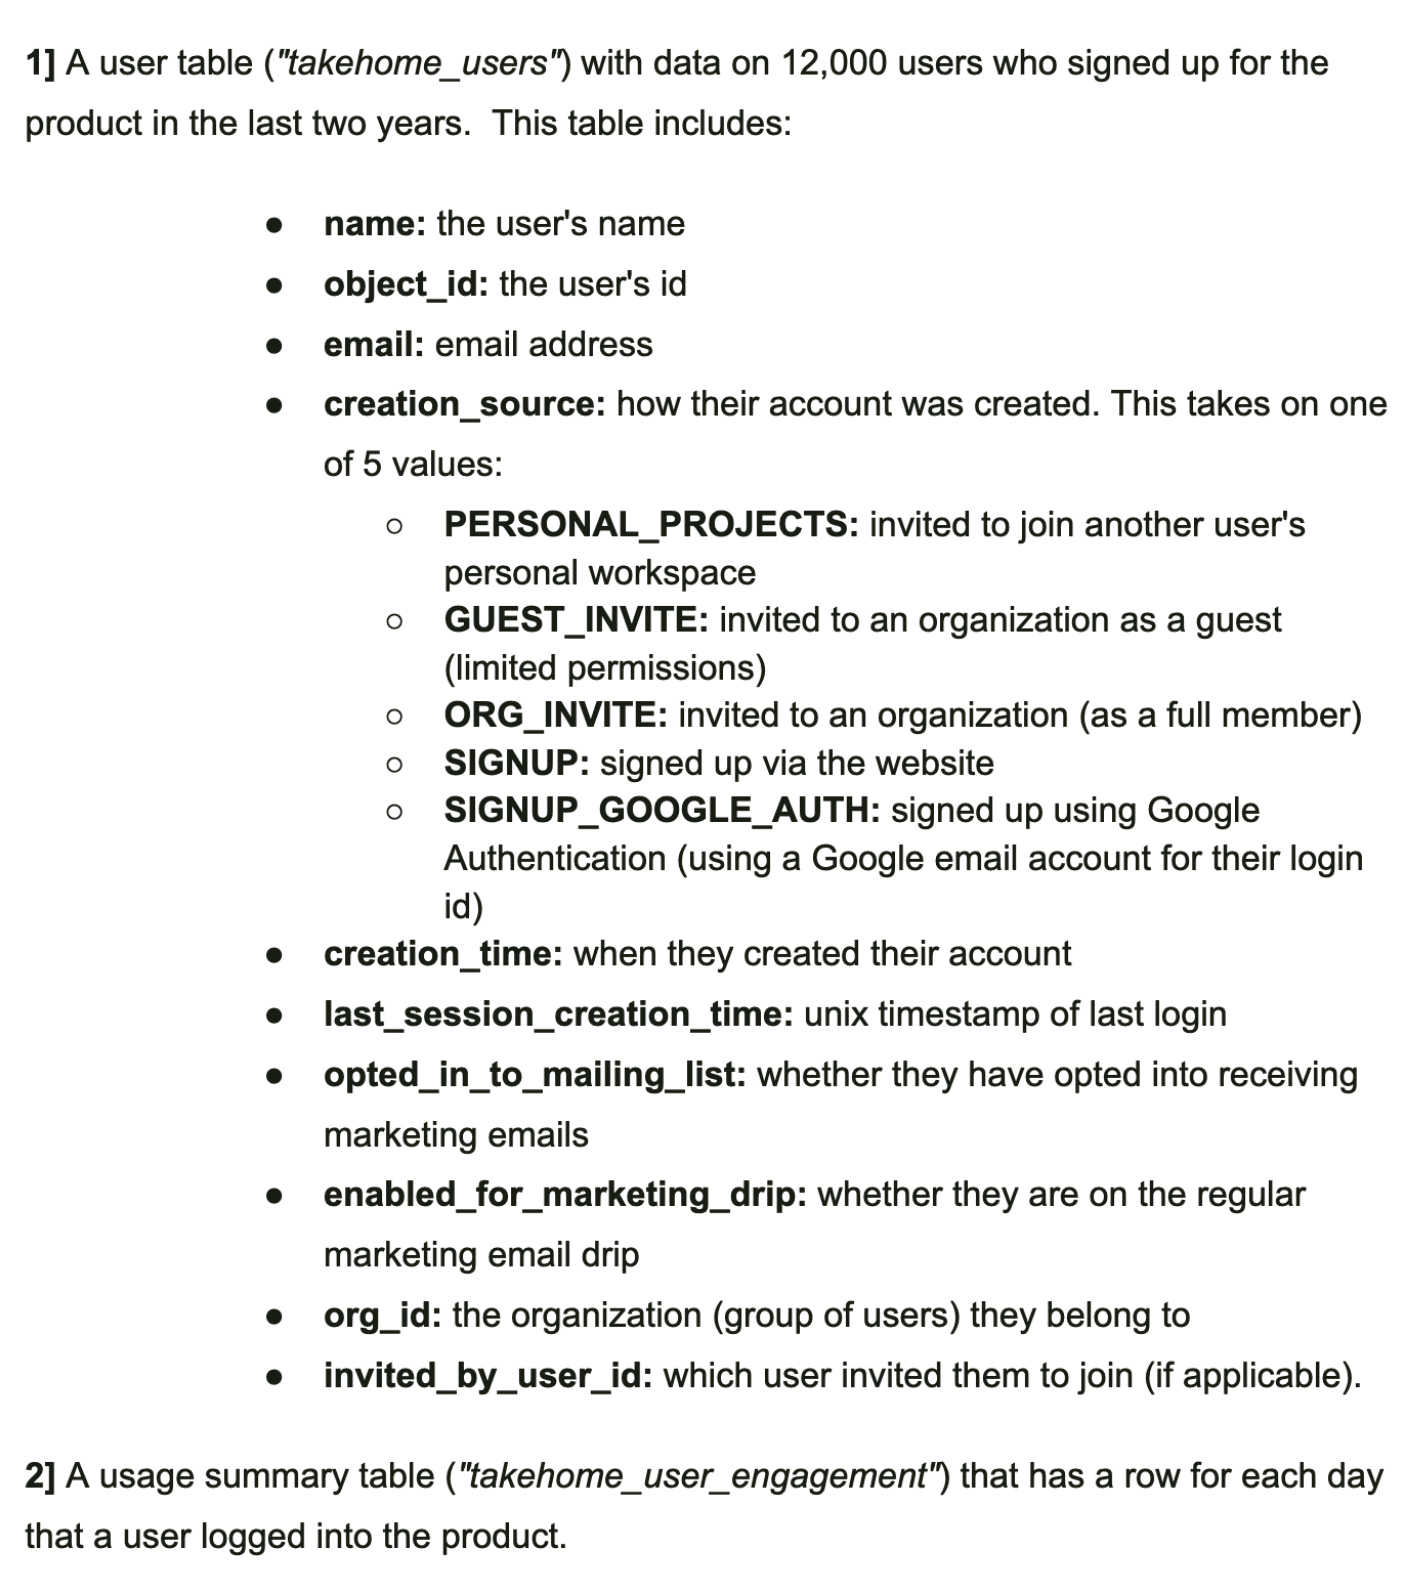

In [198]:
users = pd.read_csv('/kaggle/input/relax-datachallenge/takehome_users.csv', encoding = "iso-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [199]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [200]:
#change string to datetime type
users['creation_time'] = pd.to_datetime(users['creation_time'])
#change unix to datetime type
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

In [201]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [202]:
users.isnull().sum() * 100 / len(users)

object_id                      0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
dtype: float64

### Observations:
1. not everyone has last session recorded (~74% has last session recorded)
2. not everyone was invited by someone (only ~54% invited by someone -- virality)

In [203]:
engagement = pd.read_csv('/kaggle/input/relax-datachallenge/takehome_user_engagement.csv', encoding = "us-ascii")
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [204]:
#change string to datetime type
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [205]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [206]:
engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [207]:
# Drop visited since all rows are 1 which means all engagements are visits

engagement.drop(columns = 'visited', inplace=True)

### Adopted User Definition

A user who has logged into the product on 3 separate days in at least one 7-day period. (user can log in on 3 separate occasions for >1 7-day period; e.g. 3 log-in's in wk 1, then another 3 in wk 2)

In order to define this business logic in Python we will use Pandas' rolling function which sets a window in which we can complete an aggregate function.

In our case, we need to set a 7 day window preceeding the current row's timestamp per user and count any visits within that 7 day period.

In [208]:
def rolling_count(df, period):
    return df.rolling(period, on='time_stamp')['user_id'].count()

engagement['visits_7_days'] = engagement.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')

In [209]:
engagement.head(20)

,time_stamp,user_id,visits_7_days
0,2014-04-22 03:53:30,1,1.0
1,2013-11-15 03:45:04,2,1.0
2,2013-11-29 03:45:04,2,1.0
3,2013-12-09 03:45:04,2,1.0
4,2013-12-25 03:45:04,2,1.0
5,2013-12-31 03:45:04,2,2.0
6,2014-01-08 03:45:04,2,1.0
7,2014-02-03 03:45:04,2,1.0
8,2014-02-08 03:45:04,2,2.0
9,2014-02-09 03:45:04,2,3.0


In [210]:
# Creating adoption flag. If user's visits_7_days count is >=3 then they are considered adopted.
engagement.loc[engagement['visits_7_days'] >= 3,'adopted_user'] = 1
engagement.loc[engagement['visits_7_days'] < 3,'adopted_user'] = 0
engagement

,time_stamp,user_id,visits_7_days,adopted_user
0,2014-04-22 03:53:30,1,1.0,0.0
1,2013-11-15 03:45:04,2,1.0,0.0
2,2013-11-29 03:45:04,2,1.0,0.0
3,2013-12-09 03:45:04,2,1.0,0.0
4,2013-12-25 03:45:04,2,1.0,0.0
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1.0,0.0
207913,2013-01-15 18:28:37,11997,1.0,0.0
207914,2014-04-27 12:45:16,11998,1.0,0.0
207915,2012-06-02 11:55:59,11999,1.0,0.0


In [211]:
# get user's max counts for 7 day interval
engagement1 = engagement.groupby('user_id')[['visits_7_days']].max()
engagement1.head()

,visits_7_days
user_id,
1,1.0
2,3.0
3,1.0
4,1.0
5,1.0


In [212]:
engagement1['adopted'] = np.select(
[
    (engagement1['visits_7_days'] >= 3)
], 
[
    1
], 
default=0 )

In [213]:
engagement1.adopted.value_counts()

0    7221
1    1602
Name: adopted, dtype: int64

In [214]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN


In [215]:
# Combine users with adopted users
df = users.merge(engagement1, how = 'left', left_on = 'object_id', right_on = 'user_id', sort = True)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits_7_days,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0


In [216]:
#Another good addition to this table is first log-in time
time = engagement.groupby('user_id', as_index = False).agg({'time_stamp' : np.min})
time.head()

,user_id,time_stamp
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20


In [217]:
#Merge first log-in time with main df
df = df.merge(time, how='left', left_on = 'object_id', right_on = 'user_id', sort = True)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits_7_days,adopted,user_id,time_stamp
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0.0,1.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1.0,2.0,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0,3.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0,4.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0,5.0,2013-01-22 10:14:20


In [218]:
# Rename first log-in timestamp column to make it more clear
df = df.rename({'time_stamp':'first_login'}, axis = 'columns')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits_7_days,adopted,user_id,first_login
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0.0,1.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1.0,2.0,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0,3.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0,4.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0,5.0,2013-01-22 10:14:20


# Metrics

Before heading into our visualizations, let's take a look at what a SaaS company like Asana would be interested in measuring. This will also shed some light on what other data would be useful for this stakeholder's ask.

From *Lean Analytics*: 
* Attention - how effectively the biz attracks attn
* Enrollment - how many visitors become free/trial users, if relying on one of these to market service
* Stickiness - how much customers use producct *** this is what we are focused on with this particular analysis
* Conversion - how many of the users becoming paying customers, and how many switch to higher-paying tier
* Revenue per customer
* Customer acquisition cost (CAC)
* Virality
* Upselling
* Uptime and reliability
* Churn 
* Lifetime value (CLV)

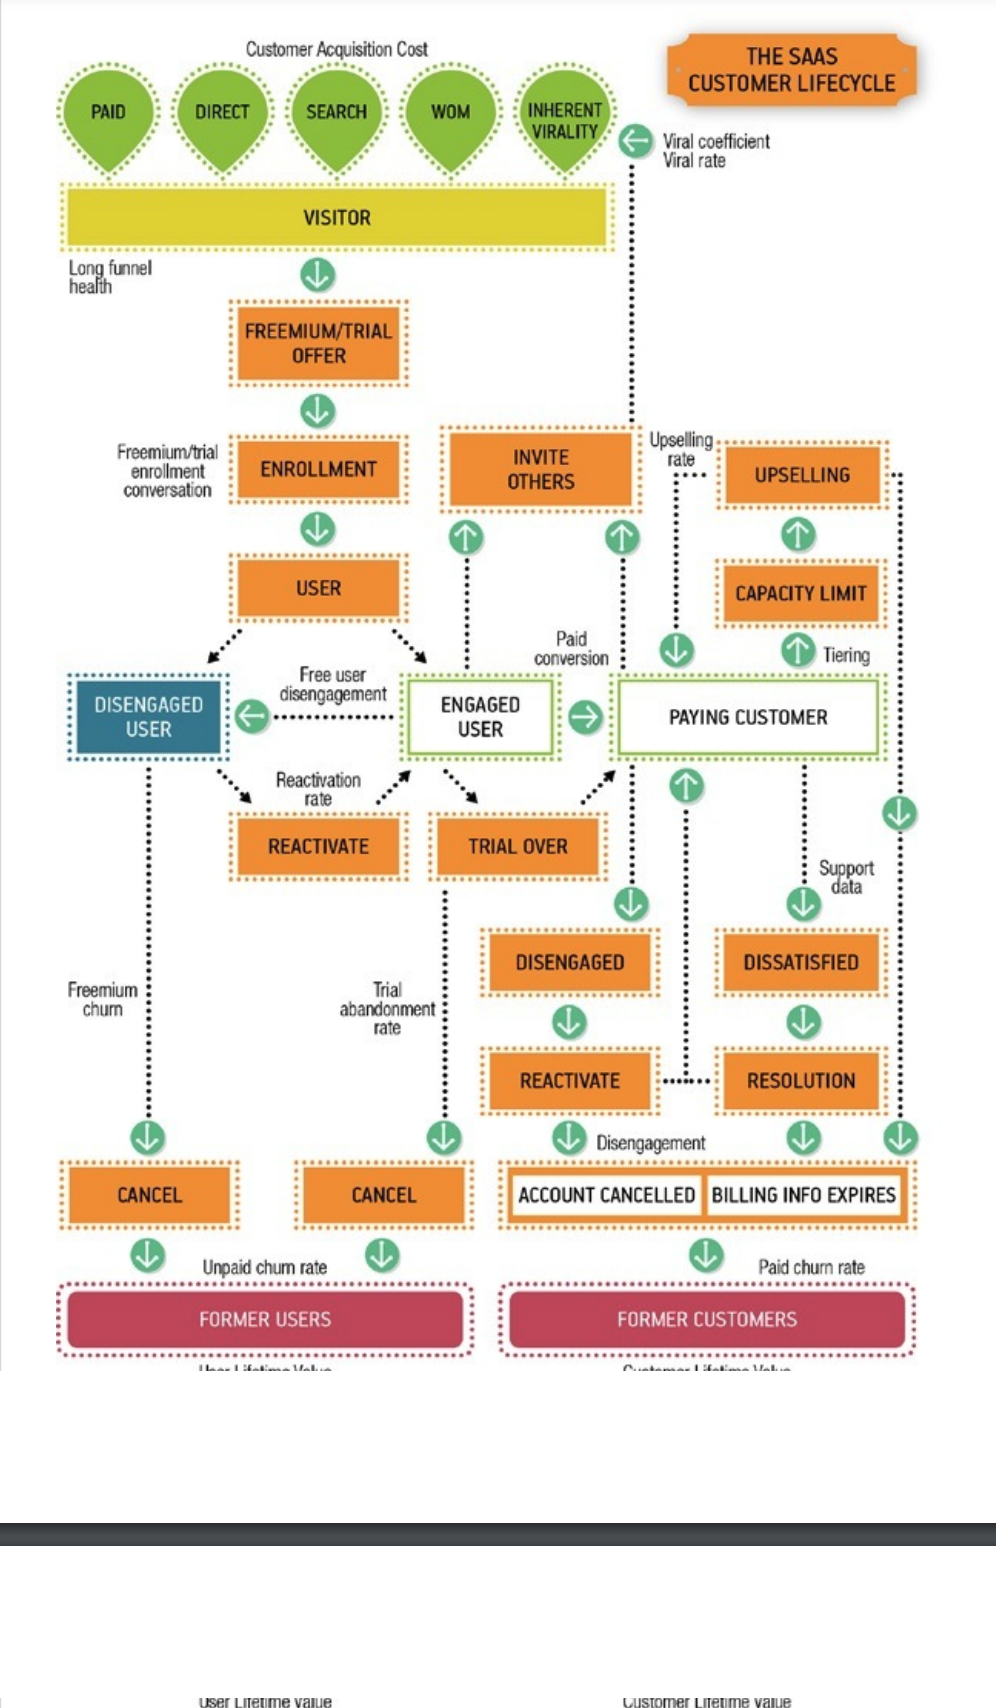

Ultimate metric for engagement is daily use. If product is not a daily use app, establishing minimum baseline of engagement takes longer, and the time it takes to iterate through a cycle of learning is longer.

Habits are hard to form-- and with any new product you're creating new habits, which you want to do as quickly as possible.



# Data That Could Help In Further Research

Great that we know that some are adopters using application at least 3x per week, but what are they actually doing inside the app.

* Are they spending only a short amount of time in the app? And is that good/bad?
* What features are they using a lot of/not a lot of?

Also, differentiating between free and paid members would be nice and looking at different demographics and engagement.

* some demographics on users would help: age, profession, city

Also, digging deeper into the Fiancial/Revenue said after getting loyal users on platform who consistenly pay for product- determine who stuck around (existing users), came back (resurrected users) and did not come back to examine ROI by calculating revenue/customer and CAC/LTV.

# EDA

Given what we know is appropriate to measure, these are the visualizations we want to build to compare non-adopted versus adopted:

1. time in which accounts were created
2. first log in session
3. last session creation time - creation time
4. creation source
5. opted into mailing list - how sticky are they
6. enabled for marketing drip
7. which org did they come from
8. were they invited by user

**combine some of these together in order to see how they interact against target - adopted

## First let us get year/month/wk/day in calendar of accounts created, first log-in and last session time

In [219]:
df['creation_time_year'] = df['creation_time'].dt.year
df['creation_time_month'] = df['creation_time'].dt.month
df['creation_time_week_in_yr'] = df['creation_time'].dt.isocalendar().week
df['creation_time_day_in_wk'] = df['creation_time'].dt.dayofweek #Mon = 0, Sat = 6
df[['creation_time', 'creation_time_year', 'creation_time_month', 'creation_time_week_in_yr', 'creation_time_day_in_wk']]

,creation_time,creation_time_year,creation_time_month,creation_time_week_in_yr,creation_time_day_in_wk
0,2014-04-22 03:53:30,2014,4,17,1
1,2013-11-15 03:45:04,2013,11,46,4
2,2013-03-19 23:14:52,2013,3,12,1
3,2013-05-21 08:09:28,2013,5,21,1
4,2013-01-17 10:14:20,2013,1,3,3
...,...,...,...,...,...
11995,2013-09-06 06:14:15,2013,9,36,4
11996,2013-01-10 18:28:37,2013,1,2,3
11997,2014-04-27 12:45:16,2014,4,17,6
11998,2012-05-31 11:55:59,2012,5,22,3


In [220]:
df['first_login'] =  pd.to_datetime(df['first_login'])
df['first_login_year'] = df['first_login'].dt.year
df['first_login_month'] = df['first_login'].dt.month
df['first_login_week_in_yr'] = df['first_login'].dt.isocalendar().week
df['first_login_day_in_wk'] = df['first_login'].dt.dayofweek #Mon = 0, Sat = 6
df.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,user_id,first_login,creation_time_year,creation_time_month,creation_time_week_in_yr,creation_time_day_in_wk,first_login_year,first_login_month,first_login_week_in_yr,first_login_day_in_wk
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,1.0,2014-04-22 03:53:30,2014,4,17,1,2014.0,4.0,17,1.0


In [221]:
df['last_session_creation_time_year'] = df['last_session_creation_time'].dt.year
df['last_session_creation_time_month'] = df['last_session_creation_time'].dt.month
df['last_session_creation_time_week_in_yr'] = df['last_session_creation_time'].dt.isocalendar().week
df['last_session_creation_time_day_in_wk'] = df['last_session_creation_time'].dt.dayofweek #Mon = 0, Sat = 6
df.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,creation_time_week_in_yr,creation_time_day_in_wk,first_login_year,first_login_month,first_login_week_in_yr,first_login_day_in_wk,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_week_in_yr,last_session_creation_time_day_in_wk
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,17,1,2014.0,4.0,17,1.0,2014.0,4.0,17,1.0


## Days in Between Account Creation Time and First Log-In Time

In [222]:
df['first_login_creation_gap'] = (df['first_login']-df['creation_time']).dt.days

In [223]:
df['first_login_creation_gap'].describe() # usually one day diff

count    8823.000000
mean        1.001813
std         1.401329
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: first_login_creation_gap, dtype: float64

## Normalize last session creation time in UNIX format

In [224]:
df.last_session_creation_time.head(20)

0    2014-04-22 03:53:30
1    2014-03-31 03:45:04
2    2013-03-19 23:14:52
3    2013-05-22 08:09:28
4    2013-01-22 10:14:20
5    2013-12-19 03:37:06
6    2012-12-20 13:24:32
7                    NaT
8                    NaT
9    2014-06-03 22:08:03
10   2013-12-27 03:55:54
11                   NaT
12   2014-03-30 16:19:38
13   2012-10-12 16:14:33
14                   NaT
15                   NaT
16   2014-04-12 14:39:38
17                   NaT
18   2013-05-30 14:56:36
19   2014-05-29 11:46:38
Name: last_session_creation_time, dtype: datetime64[ns]

In [225]:
# Create UNIX version again of last_session_creation_time and then divide by 10000000
df['last_session_creation_time_unix'] = (df['last_session_creation_time'].astype(int) / 10**9) /(10000000)
# change NaT to NaN
df.loc[~(df['last_session_creation_time_unix'] > 0), 'last_session_creation_time_unix'] = np.nan
df['last_session_creation_time_unix'].head(20) 

0     139.813881
1     139.623750
2     136.373489
3     136.921017
4     135.884966
5     138.742423
6     135.600987
7            NaN
8            NaN
9     140.183328
10    138.811655
11           NaN
12    139.619638
13    135.005847
14           NaN
15           NaN
16    139.731358
17           NaN
18    136.992580
19    140.136400
Name: last_session_creation_time_unix, dtype: float64

## Mean of Log-In Gap in Days

In [226]:
user_login_gap = engagement.groupby('user_id', group_keys=False).time_stamp.apply(lambda x: x - x.shift()).dt.days
user_login_gap = pd.DataFrame(user_login_gap)
user_login_gap.columns = ['mean_login_gap_length']
user_login_gap.head()
user_login_gap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mean_login_gap_length  199094 non-null  float64
dtypes: float64(1)
memory usage: 3.2 MB


In [227]:
user_login_gap.head()

,mean_login_gap_length
0,NaN
1,NaN
2,14.0
3,10.0
4,16.0


In [228]:
# append new feature, log-in gap in days, into df
engagement = engagement.merge(user_login_gap, left_index = True, right_index = True)

In [229]:
# get mean of log-in gap in days per user
gap_mean = engagement.groupby('user_id').agg({'mean_login_gap_length' : np.mean})
gap_mean.head()

,mean_login_gap_length
user_id,
1,NaN
2,10.461538
3,NaN
4,NaN
5,NaN


In [230]:
# join gap_mean df to the df that has all other features
df = df.merge(gap_mean, how = 'left', on = 'user_id')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,first_login_month,first_login_week_in_yr,first_login_day_in_wk,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_week_in_yr,last_session_creation_time_day_in_wk,first_login_creation_gap,last_session_creation_time_unix,mean_login_gap_length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,4.0,17,1.0,2014.0,4.0,17,1.0,0.0,139.813881,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,11.0,46,4.0,2014.0,3.0,14,0.0,0.0,139.623750,10.461538
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,3.0,12,1.0,2013.0,3.0,12,1.0,0.0,136.373489,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,5.0,21,2.0,2013.0,5.0,21,2.0,1.0,136.921017,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,1.0,4,1.0,2013.0,1.0,4,1.0,5.0,135.884966,NaN


## org_id clustered by org size

In [231]:
df.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
397      8
400      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [232]:
def org_size(x):
    value = 'small'
    if x > 300:
        value = 'large'
    elif x > 100:
        value = 'medium'
    return value

df['org_size'] = df.org_id.apply(org_size)

In [233]:
df.org_size.value_counts()

small     5782
medium    4364
large     1854
Name: org_size, dtype: int64

## Cluster e-mails together based on most popular domain names

In [234]:
df.email.value_counts()

AlfieLane@yahoo.com                 2
LasseLNrgaard@gmail.com             2
AmandaABach@gmail.com               2
PaigeWyatt@gmail.com                2
TomSchiffer@gmail.com               2
                                   ..
RodrigoMartinsOliveira@yahoo.com    1
AidanDanglow@cuvox.de               1
TylerGodfrey@gmail.com              1
AnneJKrogh@gustr.com                1
ThaisMeloLima@hotmail.com           1
Name: email, Length: 11980, dtype: int64

In [235]:
# extract email domains and make new column
df['email_domain'] = df.email.str.split('@').str[-1]
df['email_domain'].value_counts()[:20]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
mumdc.com            2
xybhi.com            2
xvnbr.com            2
luque.com            2
ydtmd.com            1
upqhn.com            1
ceqro.com            1
xagdy.com            1
gctmd.com            1
kmgtc.com            1
Name: email_domain, dtype: int64

In [236]:
def email(x):
    value = 'other'
    if x == 'gmail.com':
        value = 'gmail'
    elif x == 'yahoo.com':
        value = 'yahoo'
    elif x == 'jourrapide.com':
        value = 'jourrapide'
    elif x == 'cuvox.de':
        value = 'cuvox'
    elif x == 'gustr.com':
        value = 'gustr'
    elif x == 'hotmail.com':
        value = 'hotmail'
    return value

df['email']=df['email_domain'].apply(email)    

In [237]:
df['email'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [238]:
df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,first_login_day_in_wk,last_session_creation_time_year,last_session_creation_time_month,last_session_creation_time_week_in_yr,last_session_creation_time_day_in_wk,first_login_creation_gap,last_session_creation_time_unix,mean_login_gap_length,org_size,email_domain
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,1.0,2014.0,4.0,17,1.0,0.0,139.813881,NaN,small,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,4.0,2014.0,3.0,14,0.0,0.0,139.623750,10.461538,small,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,1.0,2013.0,3.0,12,1.0,0.0,136.373489,NaN,small,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,2.0,2013.0,5.0,21,2.0,1.0,136.921017,NaN,small,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,1.0,2013.0,1.0,4,1.0,5.0,135.884966,NaN,medium,yahoo.com


## tenure (max log-in date time from all users - account creation date time)

In [264]:
users['Tenure'] = ((datetime.datetime.today() - users['creation_time'])/np.timedelta64(1, 'D'))
users_tenure = users[['object_id','Tenure']]
users_tenure

,object_id,Tenure
0,1,3315.657442
1,2,3473.663298
2,3,3713.850937
3,4,3651.479687
4,5,3775.392974
...,...,...
11995,11996,3543.559699
11996,11997,3782.049722
11997,11998,3310.288159
11998,11999,4006.322384


In [265]:
#join tenure column to main features df
df = df.merge(users_tenure, how = 'inner', left_on = 'user_id', right_on = 'object_id')
df.head()

,object_id_x,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,last_session_creation_time_month,last_session_creation_time_week_in_yr,last_session_creation_time_day_in_wk,first_login_creation_gap,last_session_creation_time_unix,mean_login_gap_length,org_size,email_domain,object_id_y,Tenure
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,4.0,17,1.0,0.0,139.813881,NaN,small,yahoo.com,1,3315.657442
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,3.0,14,0.0,0.0,139.623750,10.461538,small,gustr.com,2,3473.663298
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,3.0,12,1.0,0.0,136.373489,NaN,small,gustr.com,3,3713.850937
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,5.0,21,2.0,1.0,136.921017,NaN,small,yahoo.com,4,3651.479687
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,1.0,4,1.0,5.0,135.884966,NaN,medium,yahoo.com,5,3775.392974


# New features to create? based on intuition and feature libraries

Ref's: 

1. https://github.com/amalrkrishna/asana-take-home/blob/master/Asana-Take-Home.ipynb
2. https://github.com/chelsealong/Asana-Data-Challenge/blob/master/Data_challenge.ipynb

- [x] break down account creation/first log in and last session times into year/month/day
- [x] first log-in time - account creation time
- [x] normalize last session creation time -- after converting from UNIX to TIMESTAMP, some timestamps are less than account creation time...
- [x] mean of log-in gap days
- [x] org_id clustered by org size
- [x] cluster different emails together based on highest e-mail domain count
- [x] tenure (max log-in date time - account creation date time)

# Verify Which Features Matter Most
* dython including caveats
* scikit-learn feature importance ranking